# DepthAI Tutorial: Training a Tiny YOLOv4 Object Detector with Your Own Data

<!-- <img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">
 -->

<img src="https://drive.google.com/uc?id=1nRyGDFel__MT2zpu_5hC1P2cHMTKJvzX" width="500">



Welcome to DepthAI! 

In this tutorial we will train an object detector using the Tiny YOLOv4 model. This model will run on our DepthAI Myriad X modules.

The model is pretrained on the COCO dataset. The framework used for training is Darknet.
Will run through the following steps:


*   Install the libraries (Darknet , etc.)
*   Clone the github repo containing images and parameter files
*   Set up model parameters and train model with medical mask images from repo
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file 

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: you can train on your own images if you replace the images in the cloned repo with your own

## STEP 1 Install Darknet


In [ ]:
%%capture
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  


## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint. 
Changes to some files need to be made according to own data, but it is nothing complicated.

In [ ]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 1726 (delta 33), reused 286 (delta 18), pack-reused 1363
Receiving objects: 100% (1726/1726), 208.92 MiB | 8.97 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Checking out files: 100% (1536/1536), done.
/content/yolotinyv3_medmask_demo


### Now go to the file explorer on the left of the colab notebook and click on content then on the yolotinyv3_medmask_demo folder.
Here you will see a folder and a few files.
The `obj` folder contains both images AND the associated annotations in yolo format. 

(to annotate own images use https://github.com/tzutalin/labelImg and save annotations in yolo format)

* the 'obj.data' file contains paths for files used by Darknet and the number of classes to train the yolo model.

* the 'obj.names' file has the labels of the objects to be detected. the number of objects gives the number of classes in the 'obj.data' file.

* the train.txt contains the path to each image to be used in training. similarly, test.txt contains the path to each image for testing. when not many images are available for training (a few hundred), use all images for training for better model performance. for the mask model we have 40 images for testing and 638 images for training. 

* the yolov4-tiny.conv.29 are the COCO pretrained weights 

* the yolov4-tiny_obj.cfg are is the tiny yolov4 configuration file that tells Darknet the model parameters and structure

So we can see that all these files need to be changed according to own data.


Then copy from your cloned repo folder with images and annotations to the `obj` folder

## Change the labels in obj.names to our current labels

In [ ]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['mask','no mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

mask
no mask

## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [ ]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 2
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/test.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

## Now we need to create a train.txt and test.txt file for our images from `obj` folder.
We will use a script that splits the images based on a specified percentage 
and writes them in train.txt and test.txt files.

In [ ]:
%cd ../yolotinyv3_medmask_demo/

/content/yolotinyv3_medmask_demo


In [ ]:
#in this case we use 6 percent as the number of images for testing.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 5 /content/yolotinyv3_medmask_demo/obj

Your image file extension is: .jpg
Number of images: 762
Number of images used for training 724
Number of images used for testing 38


## Last thing we need to change is the yolov4-tiny_obj.cfg file.
There are several parameters of importance here. They control various aspects of the training process. Let's print the first few lines and have a look


In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=1
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1



### Let's go over the parameters above:
* The batch parameter dictates the batch size. That one generally remains at 64.
* The subdivisions dictates how many images are loaded into memory. A smaller number translates to faster training. We will use 12. If a CUDA out of memory error is triggered, the subdivisions should be increased to i.e. 16,24,32 or some other number. (64 is max) Unless training with a resolution higher than 416, there should be no problem with 12.
* The width and height are by default at 416. Another resolution one can try is 320, or 608.
* The next parameter we care about is max_batches. This determines how long the training process is. Its value should be at least around 2000 for every class used. So for 3 classes, at least 6000.
* The steps are calculated as a function of max_batches. The first value is 0.8 * max_batches and the second value 0.9 * max_batches. In this case it is 8000 * 0.8 and 8000 * 0.9. 

For more details about Yolo parameters have a look here:
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
There is a lot of material here, so make sure you scroll through if you have questions. Pretty much everything is well explained.




### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=8000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch
#subdivisions define the minibatch size: minibatch = batch/subdivisions
#we set subdivisions to 4. if using larger resolutions, may have to increase
#the this number to 8 16 or even 32. default resolution is 416x416
subdivisions = 4


# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3

cfg_file = '/content/yolotinyv3_medmask_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('subdivisions=\d*','subdivisions='+str(subdivisions),s)
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



Let's look again at the configuration 

In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg



[net]
# Testing
#batch=1
#subdivisions=4
# Training
batch=64
subdivisions=4
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 8000
policy=steps
steps=6400,7200
scales=.1,.1



We also check if the number of classes and filters updated correctly

In [ ]:
!tail -n 64 /content/yolotinyv3_medmask_demo/yolov4-tiny_obj.cfg 


stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=21
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=2
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


# Train the model

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

In the `content/darknet/backup/` folder Darknet saves a few weights files:
* files that end in 1000,2000 etc are weights saved every 1000 batches
* best weights file are the weights that gave best results during training
* final weights file contains the final weights at the end of the training





## Start the model training

In [ ]:
%cd ../darknet/

/content/darknet


In [ ]:
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg /content/yolotinyv3_medmask_demo/yolov4-tiny.conv.29 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 1812071, rewritten_bbox = 0.040561 % 

 (next mAP calculation at 7800 iterations) 

 Tensor Cores are used.
 Last accuracy mAP@0.5 = 88.82 %, best = 90.09 % 
 7741: 0.166913, 0.138440 avg loss, 0.000026 rate, 0.724536 seconds, 495424 images, 0.111288 hours left
Loaded: 0.467455 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.895030, GIOU: 0.893143), Class: 0.999822, Obj: 0.990076, No Obj: 0.002373, .5R: 1.000000, .75R: 1.000000, count: 7, class_loss = 0.000475, iou_loss = 0.268816, total_loss = 0.269291 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.844072, GIOU: 0.839144), Class: 0.998893, Obj: 0.918707, No Obj: 0.004095, .5R: 1.000000, .75R: 0.885714, count: 70, class_loss = 0.422730, iou_loss = 24.448824, total_loss = 24.871553 
 total_bbox = 1812148, rewritten_bbox = 0.040560 % 
v3 (iou loss, Normalizer: (iou: 0.07,

## Check the model performance
The metrics run on the test images so they may not be fully representative, only indicative

In [ ]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->  

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->  

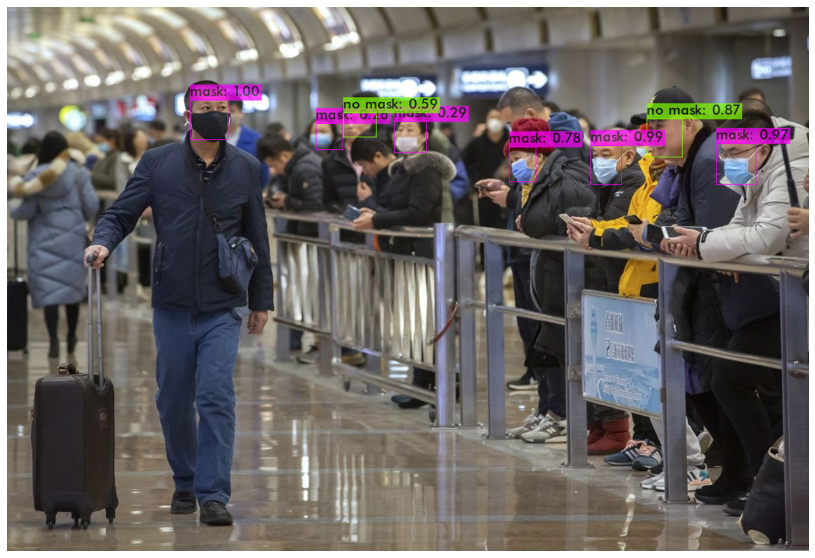

In [ ]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/yolotinyv3_medmask_demo/obj/0633.jpg -ext_output
imShow('predictions.jpg')

## Copy best weights to google drive (Optional)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/darknet/backup/yolov4-tiny_best.weights  '/content/drive/My Drive/'

# Convert model so it can be used on DepthAI
This requires three steps:
1. Convert model to Tensorflow frozen model
2. Convert Tf model to OpenVINO IR files .xml and .bin
3. Compile a blob from the IR files. The blob can be used for inference on DepthAI modules.

### Convert YOLO model to Tensorflow frozen model


In [ ]:
%cd ..

/content


In [ ]:
#clone a repo that helps with the conversion
!git clone https://github.com/TNTWEN/OpenVINO-YOLOV4.git
%cd OpenVINO-YOLOV4/

Cloning into 'OpenVINO-YOLOV4'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 252 (delta 24), reused 3 (delta 2), pack-reused 205
Receiving objects: 100% (252/252), 21.23 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/OpenVINO-YOLOV4


Convert the best yolo weights to Tensorflow frozen model. 
The name and location of the frozen model is


 `/content/tensorflow-yolo-v3/frozen_darknet_yolov4_model.pb`

In [ ]:
!python3 convert_weights_pb.py --class_names /content/yolotinyv3_medmask_demo/obj.names --data_format NHWC --weights_file /content/darknet/backup/yolov4-tiny_best.weights --tiny


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W1123 14:23:31.734161 140468210583424 module_wrapper.py:139] From convert_weights_pb.py:38: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W1123 14:23:31.735598 140468210583424 module_wrapper.py:139] From convert_weights_pb.py:40: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

Instructions for updating:
Please use `layer.__call__` method instead.
W1123 14:23:31.740380 140468210583424 deprecation.py:323] From /tensorflow-1.15.2/python3.6/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.

###Install OpenVINO 20.04

In [ ]:
%cd ..

/content


In [ ]:
%%time
%%capture
## install tools. Open Vino takes some time to download: 10-15 min sometimes.
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove
## downnload installation files
# !wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16345/l_openvino_toolkit_p_2020.1.023.tgz
# !wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16612/l_openvino_toolkit_p_2020.2.120.tgz
!wget http://registrationcenter-download.intel.com/akdlm/irc_nas/16803/l_openvino_toolkit_p_2020.4.287.tgz
# path = "l_openvino_toolkit_p_2020.1.023.tgz"
# path = "l_openvino_toolkit_p_2020.2.120.tgz"
path = "l_openvino_toolkit_p_2020.4.287.tgz"
# path = "/content/software/Intel OpenVINO 2019 R3.1/l_openvino_toolkit_p_2019.3.376.tgz"
## install openvino
!tar xf "{path}"
# %cd l_openvino_toolkit_p_2020.1.023/
%cd l_openvino_toolkit_p_2020.4.287/
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

# !bash /content/l_openvino_toolkit_p_2020.1.023/install_openvino_dependencies.sh
!bash /content/l_openvino_toolkit_p_2020.4.287/install_openvino_dependencies.sh
# !bash /content/OpenVINO-YOLOV4/l_openvino_toolkit_p_2020.4.287/install_openvino_dependencies.sh
!bash /opt/intel/openvino/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh



CPU times: user 307 ms, sys: 56 ms, total: 363 ms
Wall time: 2min 4s


###Convert frozen TF model to OpenVINO 20.04 IRv10
--input model is the path to the frozen model from above

--output_dir is where we want to save the converted IR files: .xml .bin and .mapping. we save it in TinyIR in the /content/yolotinyv3_medmask_demo directory

In [ ]:
%cd ..

/content


In [ ]:
import re
tiny_yolo_json = '/content/OpenVINO-YOLOV4/yolo_v4_tiny.json'
with open(tiny_yolo_json) as f:
    s = f.read()
s = re.sub('"classes": \d*','"classes": ' + str(len(labels)),s)
with open(tiny_yolo_json, 'w') as f:
  f.write(s)
#Check that the number of classes is correct (same as the number of your training labels)|
!cat /content/OpenVINO-YOLOV4/yolo_v4_tiny.json 

[
  {
    "id": "TFYOLOV3",
    "match_kind": "general",
    "custom_attributes": {
      "classes": 2,
      "anchors": [10, 14, 23, 27, 37, 58, 81, 82, 135, 169, 344, 319],
      "coords": 4,
      "num": 6,
      "masks": [[3, 4, 5], [1, 2, 3]],
      "entry_points": ["detector/yolo-v4-tiny/Reshape", "detector/yolo-v4-tiny/Reshape_4"]
    }
  }
]


In [ ]:
!source /opt/intel/openvino/bin/setupvars.sh && \
    python /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
--input_model /content/OpenVINO-YOLOV4/frozen_darknet_yolov4_model.pb \
--tensorflow_use_custom_operations_config /content/OpenVINO-YOLOV4/yolo_v4_tiny.json  \
--batch 1 \
--data_type FP16 \
--reverse_input_channel \
--output_dir /content/yolotinyv3_medmask_demo/TinyIR

[setupvars.sh] OpenVINO environment initialized
[ WARNING ]  Use of deprecated cli option --tensorflow_use_custom_operations_config detected. Option use in the following releases will be fatal. Please use --transformations_config cli option instead
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/OpenVINO-YOLOV4/frozen_darknet_yolov4_model.pb
	- Path for generated IR: 	/content/yolotinyv3_medmask_demo/TinyIR
	- IR output name: 	frozen_darknet_yolov4_model
	- Log level: 	ERROR
	- Batch: 	1
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	True
TensorFlow specific par

## Now we compile the IR model to a .blob for use on DepthAI modules/platform

### We save the blob in the IR directory from above, corresponding to --output_dir parameter above. 
The blob filename and location will be

 `/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.blob`

In [ ]:
#CHOOSE the directory where you would like to save the blob.
# I use the same --output_dir as above for the IR conversion
blob_dir = "/content/yolotinyv3_medmask_demo/TinyIR/"

#Copy the path of your .xml and .bin files. For that, you can look at the IR
#conversion output cell, select and copy from:
#[SUCCESS] XML file and bin file paths.
#Or you can choose to compile other .xml .bin files from a different location
#
binfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.bin"
xmlfile = "/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov4_model.xml"

import requests
from io import StringIO
class Version:
    v2019_3 = '2019.R3'
    v2020_1 = '2020.1'
    v2020_2 = '2020.2'
    v2020_3 = '2020.3'
    v2020_4 = '2020.4'
    v2021_1 = '2021.1'

url = "http://69.164.214.171:8084/compile"
params = {
    'version': Version.v2020_4
}
payload = {
    'name': 'frozen_darknet_yolov4_model',
    'myriad_shaves': 7
}
config = StringIO("""
task_type: detection
files:
  - name: FP16/frozen_darknet_yolov4_model.xml
    source:
      $type: http
      url: $REQUEST/frozen_darknet_yolov4_model.xml
  - name: FP16/frozen_darknet_yolov4_model.bin
    source:
      $type: http
      url: $REQUEST/frozen_darknet_yolov4_model.bin
framework: dldt
""")
files = {
    'config': config,
    'xml': open(xmlfile, 'rb'),
    'bin': open(binfile, 'rb')
}
response = requests.request("POST", url, data=payload, files=files, params=params)
print(response.headers.get('Content-Disposition'))
print(response.headers)
blobnameraw = response.headers.get('Content-Disposition')
blobname = blobnameraw[blobnameraw.find('='):][1:]
with open(blob_dir + blobname, 'wb') as f:
  f.write(response.content)

attachment; filename=medmask-tyv4_colab90.blob
{'Content-Disposition': 'attachment; filename=medmask-tyv4_colab90.blob', 'Content-Length': '11813888', 'Content-Type': 'application/octet-stream', 'Last-Modified': 'Fri, 27 Nov 2020 12:20:36 GMT', 'Cache-Control': 'public, max-age=43200', 'Expires': 'Sat, 28 Nov 2020 00:20:38 GMT', 'ETag': '"1606479636.234763-11813888-4041351725"', 'Server': 'Werkzeug/1.0.1 Python/3.6.9', 'Date': 'Fri, 27 Nov 2020 12:20:38 GMT'}


##Now you can download your .blob file and run it on the DepthAI module/platform
To download locally, use the file explorer on the left to locate the file in the blob_dir folder used above, then right click download. Colab takes a few seconds to prepare the file, then the download prompt will appear.

In [ ]:
#name the archive as you see fit
!tar cvf medmask_tinyv3.tar /content/yolotinyv3_medmask_demo/TinyIR 

tar: Removing leading `/' from member names
/content/yolotinyv3_medmask_demo/TinyIR/
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.blob
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.mapping
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.xml
/content/yolotinyv3_medmask_demo/TinyIR/frozen_darknet_yolov3_model.bin


## To run the .blob in DepthAI, follow step 5 here:
 https://docs.luxonis.com/tutorials/object_det_mnssv2_training/

##[Optional] to convert the blob locally, download the IR files .bin and .xml and follow these instructions: https://github.com/luxonis/depthai#conversion-of-existing-trained-models-into-intel-movidius-binary-format